# Analyzing Telco Client Behavior to Identify Prepaid Plans with Higher Revenue Potential

## Project Description

Megaline, a telecom operator, offers two prepaid packages, Surf and Ultimate. The advertising department aims to optimize the advertising budget by identifying which prepaid plan generates more revenue.

In this analysis, we will examine a sample of 500 Megaline clients and explore their behavior, including their identity, origin, package type, and usage statistics such as the number of calls and messages sent in 2018. By analyzing client behavior, we aim to determine which prepaid package brings in higher revenue for Megaline.

## Prepaid Package Description

Megaline applies rounding rules for call duration and data usage. Call duration is rounded up to the nearest minute, meaning even a one-second call will be counted as one minute. Data usage, on the other hand, is rounded up to the nearest gigabyte. For example, if a user consumes 1025 megabytes in a month, they will be charged for 2 gigabytes.

Below are the details of the Surf and Ultimate prepaid plans:

**Surf:**
- Monthly fee: USD20
- Includes 500 minutes of call duration, 50 SMS, and 15 GB of data per month
- Charges for exceeding the package limits:
   - USD0.03 per minute for calls
   - USD0.03 per SMS
   - USD10 per gigabyte of data

**Ultimate:**
- Monthly fee: USD70
- Includes 3000 minutes of call duration, 1000 SMS, and 30 GB of data per month
- Charges for exceeding the package limits:
   - USD0.01 per minute for calls
   - USD0.01 per SMS
   - USD7 per gigabyte of data

## Data Description

We have obtained five data files for this analysis, each containing different information. Here is a description of each data file:

**megaline_users (user data):**
- user_id: User ID
- first_name: User's first name
- last_name: User's last name
- age: User's age in years
- reg_date: Subscription start date (dd, mm, yy)
- churn_date: Date when the user stopped using the service (if missing, it means the service plan was in use when the data was generated)
- city: City where the user lives
- plan: Name of the phone plan

**megaline_calls (call data):**
- id: Unique ID for each web session
- call_date: Date of the call
- duration: Duration of the call in minutes
- user_id: User ID of the caller

**megaline_messages (SMS data):**
- id: Unique SMS ID
- message_date: Date when the SMS was sent
- user_id: User ID of the sender

**megaline_internet (web session data):**
- id: Unique ID for each web session
- mb_used: Volume of data consumed during the session in megabytes
- session_date: Date of the web session
- user_id: User ID

**megaline_plans (phone package data):**
- plan_name: Phone plan name
- usd_monthly_fee: Monthly fee in US dollars
- minutes_included: Monthly call minute allocation
- messages_included: Monthly SMS allocation
- mb_per_month_included: Monthly data volume allocation in megabytes
- usd_per_minute: Price per minute if the package allocation limit has been exceeded
- usd_per_message: Price per SMS if the package allocation limit has been exceeded
- usd_per_gb: Price per extra gigabyte of data if the package allocation limit has been exceeded (1 GB = 1024 megabytes)

## Hypothesis

We were assigned to test two hypotheses in this analysis, namely:
- The average revenue of Ultimate and Surf phone package users is different.
- The average income of users in the NY-NJ area is different from the income of users from other regions.

## Data Pre-processing

### Import Libraries

We will use some Python libraries to complete this analysis.

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

### Open and Read Data

We get five data frames to work with. We will study the content, find any errors and fix them.

In [2]:
# Read the data and store it in a new variable.
calls = pd.read_csv('megaline_calls.csv')
internet = pd.read_csv('megaline_internet.csv')
messages = pd.read_csv('megaline_messages.csv')
plans = pd.read_csv('megaline_plans.csv')
users = pd.read_csv('megaline_users.csv')

In [3]:
# Checking the general information of the calls data
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Findings:
- There is no missing data.
- The `call_date` column is still in string format and needs to be converted to datetime format.
- The `duration` column contains decimal values. Based on the instructions we received, each fractional value in the call duration should be rounded up to the nearest whole number.

In [4]:
# Checking the general information of the internet data
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Findings:
- There are no missing values, but there is a row with a 'mb_used' value of 0.00. This could be due to the data not being used and can be ignored.
- There are fewer data lines compared to calls.
- The `session_date` column needs to be converted to datetime format.
- According to the instructions we received, internet data is measured in megabytes (MB), so there is no need to round the data at this stage. The rounding will be performed later when grouping the data by month.

In [5]:
# Checking the general information of the messages data
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Findings:
- There are no missing values in the dataset.
- The `message_date` column needs to be converted to datetime format.

In [6]:
# Checking the general information of the plans data
plans.info()
plans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Findings:

- This table consists of only two rows, providing information about each package.
- The `mb_per_month_included` column represents internet data in megabytes. We will convert it to gigabytes (GB).

In [7]:
# Checking the general information of the users data
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Findings:

- There are a significant number of NaN values in the `churn_date` column, indicating that the package is still actively being used by the user. The `churn_date` column represents the date when the user stopped using the service.
- The `reg_date` and `churn_date` columns need to be converted to datetime data type.
- The `city` column contains excessive information. We only require the city code.

### Fix the Data

There are several common data errors, particularly with the date data type, which is currently in string/object format. For this analysis, we only need the monthly data. We will disregard the specific date format in the columns containing date data, but we will create a new column of datetime type that represents the month only.

In [8]:
# Create a function to generate a column representing the month period.
def to_month(dataset, col_name):
    temp_array = pd.to_datetime(dataset[col_name])
    temp_array = temp_array.dt.to_period("M")
    return temp_array

In [9]:
# Add a `month` column to the calls dataset and display the results
calls['month'] = to_month(calls, 'call_date')
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype    
---  ------     --------------   -----    
 0   id         137735 non-null  object   
 1   user_id    137735 non-null  int64    
 2   call_date  137735 non-null  object   
 3   duration   137735 non-null  float64  
 4   month      137735 non-null  period[M]
dtypes: float64(1), int64(1), object(2), period[M](1)
memory usage: 5.3+ MB


,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,2018-12
1,1000_145,1000,2018-12-27,13.66,2018-12
2,1000_247,1000,2018-12-27,14.48,2018-12
3,1000_309,1000,2018-12-28,5.76,2018-12
4,1000_380,1000,2018-12-30,4.22,2018-12


The functions are working correctly. We will apply them to the other datasets.

In [10]:
# Add a `month` column to the internet dataset and display the results
internet['month'] = to_month(internet, 'session_date')
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype    
---  ------        --------------   -----    
 0   id            104825 non-null  object   
 1   user_id       104825 non-null  int64    
 2   session_date  104825 non-null  object   
 3   mb_used       104825 non-null  float64  
 4   month         104825 non-null  period[M]
dtypes: float64(1), int64(1), object(2), period[M](1)
memory usage: 4.0+ MB


,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,2018-12
1,1000_204,1000,2018-12-31,0.00,2018-12
2,1000_379,1000,2018-12-28,660.40,2018-12
3,1000_413,1000,2018-12-26,270.99,2018-12
4,1000_442,1000,2018-12-27,880.22,2018-12


In [11]:
# Add a `month` column to the messages dataset and display the results
messages['month'] = to_month(messages, 'message_date')
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   id            76051 non-null  object   
 1   user_id       76051 non-null  int64    
 2   message_date  76051 non-null  object   
 3   month         76051 non-null  period[M]
dtypes: int64(1), object(2), period[M](1)
memory usage: 2.3+ MB


,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,2018-12
1,1000_160,1000,2018-12-31,2018-12
2,1000_223,1000,2018-12-31,2018-12
3,1000_251,1000,2018-12-27,2018-12
4,1000_255,1000,2018-12-26,2018-12


The newly created 'month' column will be valuable for data grouping and merging in the future. Additionally, we will standardize the data types of the `reg_date` and `churn_date` columns in the users table to match the month-based format of the data in other tables.

In [12]:
# Change the data types of the `reg_date` and `churn_date` columns in the users dataset and display the results
users['reg_month'] = to_month(users, 'reg_date')
users['churn_month'] = to_month(users, 'churn_date')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   user_id      500 non-null    int64    
 1   first_name   500 non-null    object   
 2   last_name    500 non-null    object   
 3   age          500 non-null    int64    
 4   city         500 non-null    object   
 5   reg_date     500 non-null    object   
 6   plan         500 non-null    object   
 7   churn_date   34 non-null     object   
 8   reg_month    500 non-null    period[M]
 9   churn_month  34 non-null     period[M]
dtypes: int64(2), object(6), period[M](2)
memory usage: 39.2+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,churn_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,2018-12,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,2018-08,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,2018-10,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,2018-01,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,2018-05,NaT


Next, we will clean up the information in the `city` column of the users dataset and add a new column called `city_code`.

In [13]:
# Add a `city_code` column to the users dataset and display the results
users['city_code'] = users['city'].str.split(', ').str[1]
users['city_code'] = users['city_code'].str.replace(' MSA', '')
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,churn_month,city_code
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,2018-12,NaT,GA
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,2018-08,NaT,WA
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,2018-10,NaT,NV
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,2018-01,NaT,OK
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,2018-05,NaT,WA


Next, we round up the `duration` column in the calls dataset.

In [14]:
# Round up the values in the `duration` column.
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype('int')
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype    
---  ------     --------------   -----    
 0   id         137735 non-null  object   
 1   user_id    137735 non-null  int64    
 2   call_date  137735 non-null  object   
 3   duration   137735 non-null  int32    
 4   month      137735 non-null  period[M]
dtypes: int32(1), int64(1), object(2), period[M](1)
memory usage: 4.7+ MB


,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,2018-12
1,1000_145,1000,2018-12-27,14,2018-12
2,1000_247,1000,2018-12-27,15,2018-12
3,1000_309,1000,2018-12-28,6,2018-12
4,1000_380,1000,2018-12-30,5,2018-12


Next, we will convert the information in the `mb_per_month_included` column of the data plans to gigabytes (GB), round up the values, and update the column names accordingly.

In [15]:
# Changed mb to gb in the `mb_per_month_included` column in the plans dataset
plans['mb_per_month_included'] = plans['mb_per_month_included']/1024
plans['mb_per_month_included'] = plans['mb_per_month_included'].apply(np.ceil).astype('int')
plans = plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'})
plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


### Data Manipulation

After data cleaning, we will transform the data to align with the requirements of this analysis. The data we have received is in daily granularity, while the current analysis requires monthly data per user. Hence, we will reorganize the data by grouping it based on the `user_id` and `month` columns that were previously created.

In [16]:
# Group the data in the calls dataset into monthly periods
calls = pd.pivot_table(calls, index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()
calls.head()

,user_id,month,duration
0,1000,2018-12,124
1,1001,2018-08,182
2,1001,2018-09,315
3,1001,2018-10,393
4,1001,2018-11,426


In [17]:
# Group the data in the internet dataset into monthly periods
internet = pd.pivot_table(internet, index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
internet.head()

,user_id,month,mb_used
0,1000,2018-12,1901.47
1,1001,2018-08,6919.15
2,1001,2018-09,13314.82
3,1001,2018-10,22330.49
4,1001,2018-11,18504.30


According to the instructions we received, we need to round up the monthly internet data to gigabytes. To accommodate this, we will add a new column called `gb_used`, where 1 GB is equivalent to 1024 MB. If the result is a fraction, we will round it up to the nearest whole number.

In [18]:
# Add the column `gb_used` to the internet dataset
internet['gb_used'] = np.ceil(internet['mb_used'] / 1024).astype('int')
internet.head()

,user_id,month,mb_used,gb_used
0,1000,2018-12,1901.47,2
1,1001,2018-08,6919.15,7
2,1001,2018-09,13314.82,14
3,1001,2018-10,22330.49,22
4,1001,2018-11,18504.30,19


In [19]:
# Group the data in the messages dataset into monthly periods
messages = pd.pivot_table(messages, index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages.columns = ('user_id', 'month', 'sms')
messages.head()

,user_id,month,sms
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36


All the required data has been grouped by `user_id` and `month`. Now, we can merge all this data into a single table.

In [20]:
# Merge all datasets into one and store it in a variable named "dataset"
dataset = internet.merge(calls, on=['user_id', 'month'], how='left')
dataset = dataset.merge(messages, on=['user_id', 'month'], how='left')
dataset = dataset.merge(users, on=['user_id'], how='left')
dataset = dataset.merge(plans, left_on='plan', right_on='plan_name', how='left')
dataset.head()

,user_id,month,mb_used,gb_used,duration,sms,first_name,last_name,age,city,...,churn_month,city_code,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,2018-12,1901.47,2,124.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,NaT,GA,1000,30,3000,70,7,0.01,0.01,ultimate
1,1001,2018-08,6919.15,7,182.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,NaT,WA,50,15,500,20,10,0.03,0.03,surf
2,1001,2018-09,13314.82,14,315.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,NaT,WA,50,15,500,20,10,0.03,0.03,surf
3,1001,2018-10,22330.49,22,393.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,NaT,WA,50,15,500,20,10,0.03,0.03,surf
4,1001,2018-11,18504.30,19,426.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,NaT,WA,50,15,500,20,10,0.03,0.03,surf


We deleted some columns that are not relevant for the purposes of this analysis.

In [21]:
# Remove irrelevant columns
drop_cols = ['first_name', 'last_name', 'city', 'mb_used', 'reg_date', 'churn_date']
dataset.drop(drop_cols, axis=1, inplace=True)
dataset.head()

,user_id,month,gb_used,duration,sms,age,plan,reg_month,churn_month,city_code,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,2018-12,2,124.0,11.0,45,ultimate,2018-12,NaT,GA,1000,30,3000,70,7,0.01,0.01,ultimate
1,1001,2018-08,7,182.0,30.0,28,surf,2018-08,NaT,WA,50,15,500,20,10,0.03,0.03,surf
2,1001,2018-09,14,315.0,44.0,28,surf,2018-08,NaT,WA,50,15,500,20,10,0.03,0.03,surf
3,1001,2018-10,22,393.0,53.0,28,surf,2018-08,NaT,WA,50,15,500,20,10,0.03,0.03,surf
4,1001,2018-11,19,426.0,36.0,28,surf,2018-08,NaT,WA,50,15,500,20,10,0.03,0.03,surf


In [22]:
# Checking the new dataset size
dataset.shape

(2277, 18)

We will filter the dataset to include only active users, ignoring the data for users who are considered inactive in certain months.

In [23]:
# Filter the unnecessary datasets
dataset = dataset.loc[((dataset.reg_month <= dataset.month) & \
                       (dataset.churn_month >= dataset.month)) | (dataset.churn_month.isnull())]
dataset.shape

(2240, 18)

## Data Analysis

We have obtained comprehensive data on the number of minutes, messages, and data usage per package per month for each user. It is now time to analyze this data.

Objective:
The objective is to determine which prepaid plan generates more revenue in order to adjust the advertising budget.

Guiding Questions:
1. What is the total monthly revenue generated by each package?
2. How many users exceed the allocated limits and pay extra for each plan?
3. What is the average monthly usage of calls, SMS, and data per user for each package?
4. How is the distribution of call duration per month for each package?
5. How is the distribution of internet usage per month for each package?
6. How is the distribution of SMS per month for each package?
7. Is there a relationship between a user's age and their usage level of prepaid service packages?
8. Is there a relationship between a user's city location and their usage level of prepaid service packages?

**Revenue Per Package**

To determine the revenue per plan, we need to identify any additional fees that users incur for exceeding their usage limits. These fees will be added to the regular subscription fee.

In [24]:
# Calculate extra costs
def extra_price (value, max_value, cost_extra):
    extra_value = value - max_value
    if extra_value > 0:
        return cost_extra * extra_value
    else:
        return 0

In [25]:
# Add a new column to calculate the total cost
dataset['extra_internet'] = dataset.apply(lambda row: extra_price(value=row['gb_used'], 
                                                                  max_value=row['gb_per_month_included'], 
                                                                  cost_extra=row['usd_per_gb']), axis=1)
dataset['extra_messages'] = dataset.apply(lambda row: extra_price(value=row['sms'], 
                                                                  max_value=row['messages_included'], 
                                                                  cost_extra=row['usd_per_message']), axis=1)
dataset['extra_calls'] = dataset.apply(lambda row: extra_price(value=row['duration'], 
                                                               max_value=row['minutes_included'], 
                                                               cost_extra=row['usd_per_minute']), axis=1)
dataset['total_extra_cost'] = dataset[['extra_internet', 'extra_messages', 'extra_calls' ]].sum(axis=1)
dataset['total_cost'] = dataset[['total_extra_cost', 'usd_monthly_pay']].sum(axis=1)
dataset.head()

,user_id,month,gb_used,duration,sms,age,plan,reg_month,churn_month,city_code,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,extra_internet,extra_messages,extra_calls,total_extra_cost,total_cost
0,1000,2018-12,2,124.0,11.0,45,ultimate,2018-12,NaT,GA,...,70,7,0.01,0.01,ultimate,0,0.00,0.0,0.00,70.00
1,1001,2018-08,7,182.0,30.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,0,0.00,0.0,0.00,20.00
2,1001,2018-09,14,315.0,44.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,0,0.00,0.0,0.00,20.00
3,1001,2018-10,22,393.0,53.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,70,0.09,0.0,70.09,90.09
4,1001,2018-11,19,426.0,36.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,40,0.00,0.0,40.00,60.00


In [26]:
# Checking the monthly progress of the number of users for each package and storing it in the variable `income_user`
income_user = dataset.groupby(['plan', 'month']).count()['user_id'].reset_index()
income_user

,plan,month,user_id
0,surf,2018-01,2
1,surf,2018-02,9
2,surf,2018-03,23
3,surf,2018-04,49
4,surf,2018-05,76
5,surf,2018-06,95
6,surf,2018-07,120
7,surf,2018-08,159
8,surf,2018-09,193
9,surf,2018-10,230


The number of users increases every month.

In [27]:
# Find out the monthly income for each package and store it in the income variable
income = dataset.groupby(['plan', 'month']).sum()[['usd_monthly_pay', 'total_extra_cost', 'total_cost']].reset_index()
income['month'] = income['month'].astype(str)
income

,plan,month,usd_monthly_pay,total_extra_cost,total_cost
0,surf,2018-01,40,0.00,40.00
1,surf,2018-02,180,129.57,309.57
2,surf,2018-03,460,596.65,1056.65
3,surf,2018-04,980,1035.53,2015.53
4,surf,2018-05,1520,2127.34,3647.34
5,surf,2018-06,1900,2835.36,4735.36
6,surf,2018-07,2400,5159.93,7559.93
7,surf,2018-08,3180,7111.72,10291.72
8,surf,2018-09,3860,7422.27,11282.27
9,surf,2018-10,4600,10614.81,15214.81


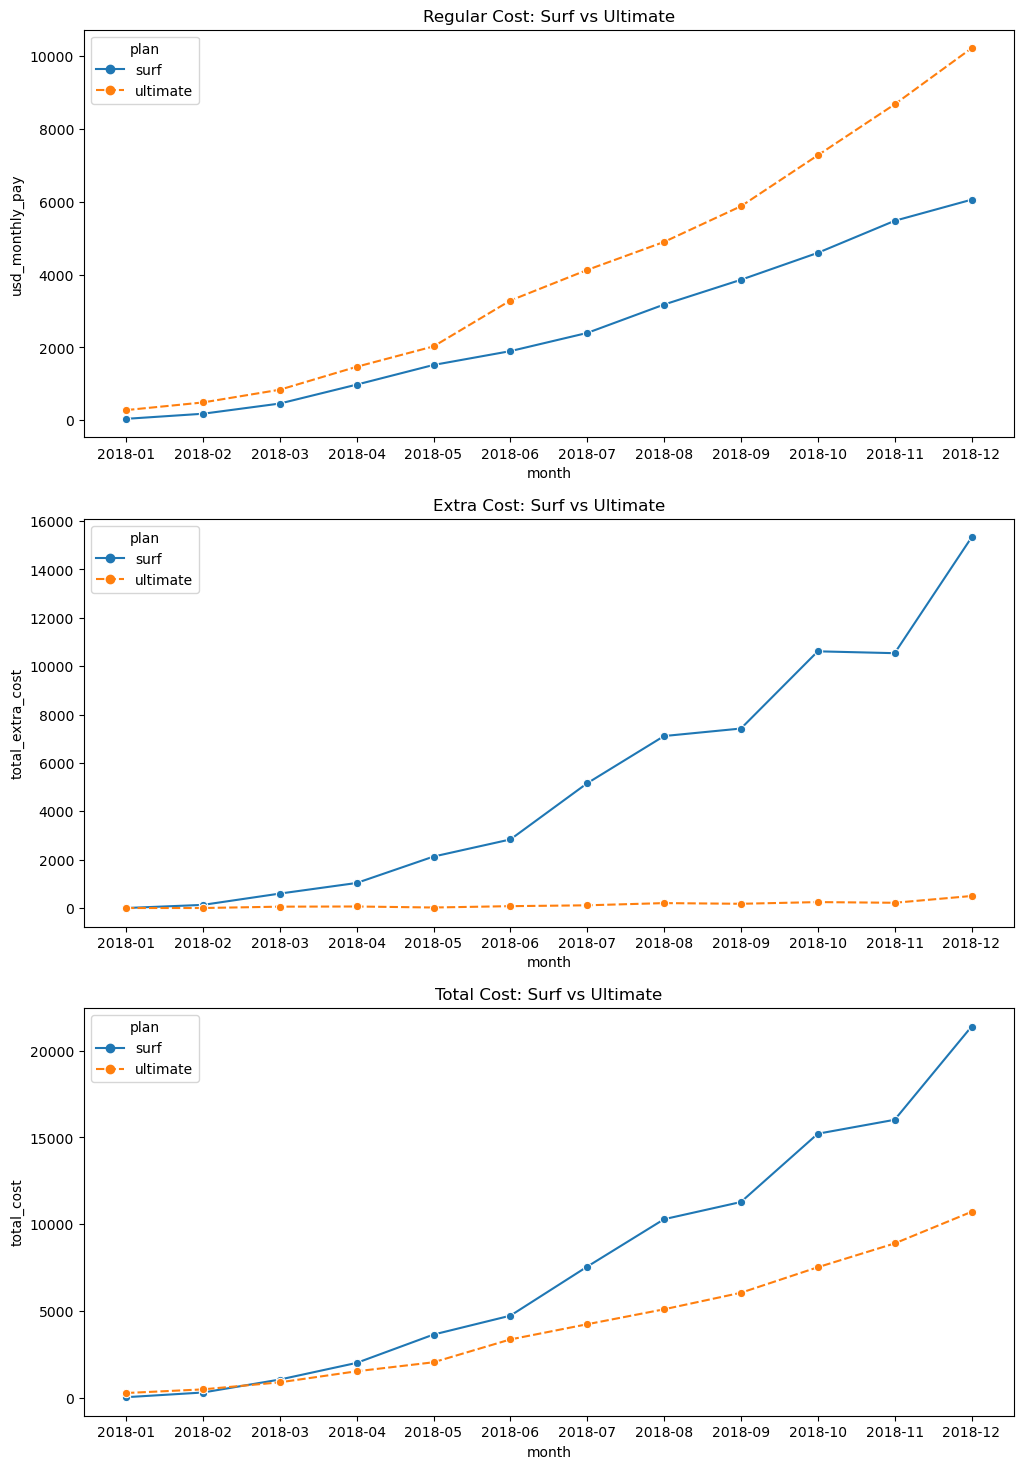

In [28]:
# Surf vs Ultimate earnings comparison
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
plt.title('Regular Cost: Surf vs Ultimate')
sns.lineplot(data=income, x='month', y='usd_monthly_pay', hue='plan', style="plan", markers=["o", "o"])

plt.subplot(3, 1, 2)
plt.title('Extra Cost: Surf vs Ultimate')
sns.lineplot(data=income, x='month', y='total_extra_cost', hue='plan', style="plan", markers=["o", "o"])

plt.subplot(3, 1, 3)
plt.title('Total Cost: Surf vs Ultimate')
sns.lineplot(data=income, x='month', y='total_cost', hue='plan', style="plan", markers=["o", "o"])

plt.show()

**Findings:**
- The number of users in each package continues to increase from month to month, resulting in increased revenue for each package.
- By the end of the year (December), the number of Surf package users was twice the number of Ultimate package users (303 vs 146).
- The regular income for each package increases in line with the monthly increase in the number of users.
- Surf customers incur significantly higher extra fees compared to Ultimate customers. In fact, Ultimate customers are less likely to exceed their usage limits and incur extra costs.
- The high extra fees for Surf packages contribute to a higher total cost paid by Surf package customers compared to Ultimate package customers.
- The extra costs incurred by Surf customers actually exceed the regular costs of the Surf package itself and even surpass the regular costs of Ultimate customers.

**Insights:**
- Customers tend to choose the cheaper Surf packages, even though their usage levels often exceed the limits provided by those packages.
- Customers prioritize affordability over purchasing more expensive packages that offer higher service limits from the start.

**Recommendation:**
- Promoting Surf packages would be more profitable as it attracts customers with its perceived affordability. Despite its lower initial cost, this package generates greater profits for the company in the long run.

To gain a more accurate understanding of the data, we will calculate the average revenue per user per month for each plan.

In [29]:
# Calculating the average income per user per package and storing it in the variable `income_data`
income_user['month'] = income_user['month'].astype(str)
income_data = income_user.merge(income, on=['plan', 'month'], how='left')
income_data['average_cost_per_user'] = income_data['total_cost'] / income_data['user_id']
income_data

,plan,month,user_id,usd_monthly_pay,total_extra_cost,total_cost,average_cost_per_user
0,surf,2018-01,2,40,0.00,40.00,20.000000
1,surf,2018-02,9,180,129.57,309.57,34.396667
2,surf,2018-03,23,460,596.65,1056.65,45.941304
3,surf,2018-04,49,980,1035.53,2015.53,41.133265
4,surf,2018-05,76,1520,2127.34,3647.34,47.991316
5,surf,2018-06,95,1900,2835.36,4735.36,49.845895
6,surf,2018-07,120,2400,5159.93,7559.93,62.999417
7,surf,2018-08,159,3180,7111.72,10291.72,64.727799
8,surf,2018-09,193,3860,7422.27,11282.27,58.457358
9,surf,2018-10,230,4600,10614.81,15214.81,66.151348


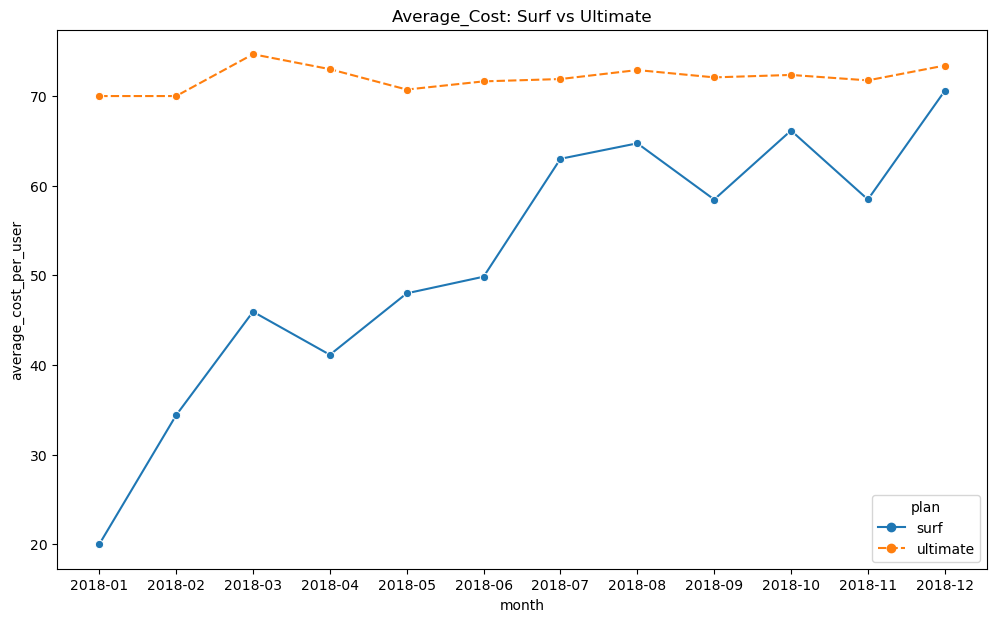

In [30]:
# Displaying a visualization of the average revenue per package
plt.figure(figsize=(12, 7))
plt.title('Average_Cost: Surf vs Ultimate')
sns.lineplot(data=income_data, x='month', y='average_cost_per_user', hue='plan', style="plan", markers=["o", "o"])
plt.show()

**Findings:**
- The average cost per user for the ultimate package remains stable, despite the increasing number of users each month.
- In contrast, the average cost per user for surf packages tends to increase over time.

**Insights:**
- In addition to having a larger number of surf package subscribers, they also tend to continue spending more on purchasing prepaid packages.
- The results of calculating the average cost per customer align with the previous findings regarding total revenue per customer, which indicate an exponential growth trend in surf packages.
- Ultimately, the total costs incurred by surf customers approach those of ultimate customers who initially paid more.

**Recommendation:**
- Once again, promoting surf packages will be more profitable for the company.

We have discovered that the revenue generated from the extra fees on the surf package actually exceeds both the regular surf package fee and the regular fee of the ultimate package. It is important to determine the main contributors to this increase in costs, whether it is due to internet usage, telephone calls, or SMS messages.

In [31]:
# Comparison of extra costs on internet, telephone and sms
income_extra = dataset.groupby(['plan', 'month']).sum()[['extra_internet', 'extra_messages', 'extra_calls' ]].reset_index()
income_extra['month'] = income_extra['month'].astype(str)
income_extra

,plan,month,extra_internet,extra_messages,extra_calls
0,surf,2018-01,0,0.00,0.00
1,surf,2018-02,120,0.24,9.33
2,surf,2018-03,580,0.39,16.26
3,surf,2018-04,980,2.61,52.92
4,surf,2018-05,1990,9.63,127.71
5,surf,2018-06,2670,12.00,153.36
6,surf,2018-07,4880,14.67,265.26
7,surf,2018-08,6820,26.46,265.26
8,surf,2018-09,7110,33.69,278.58
9,surf,2018-10,10140,55.71,419.10


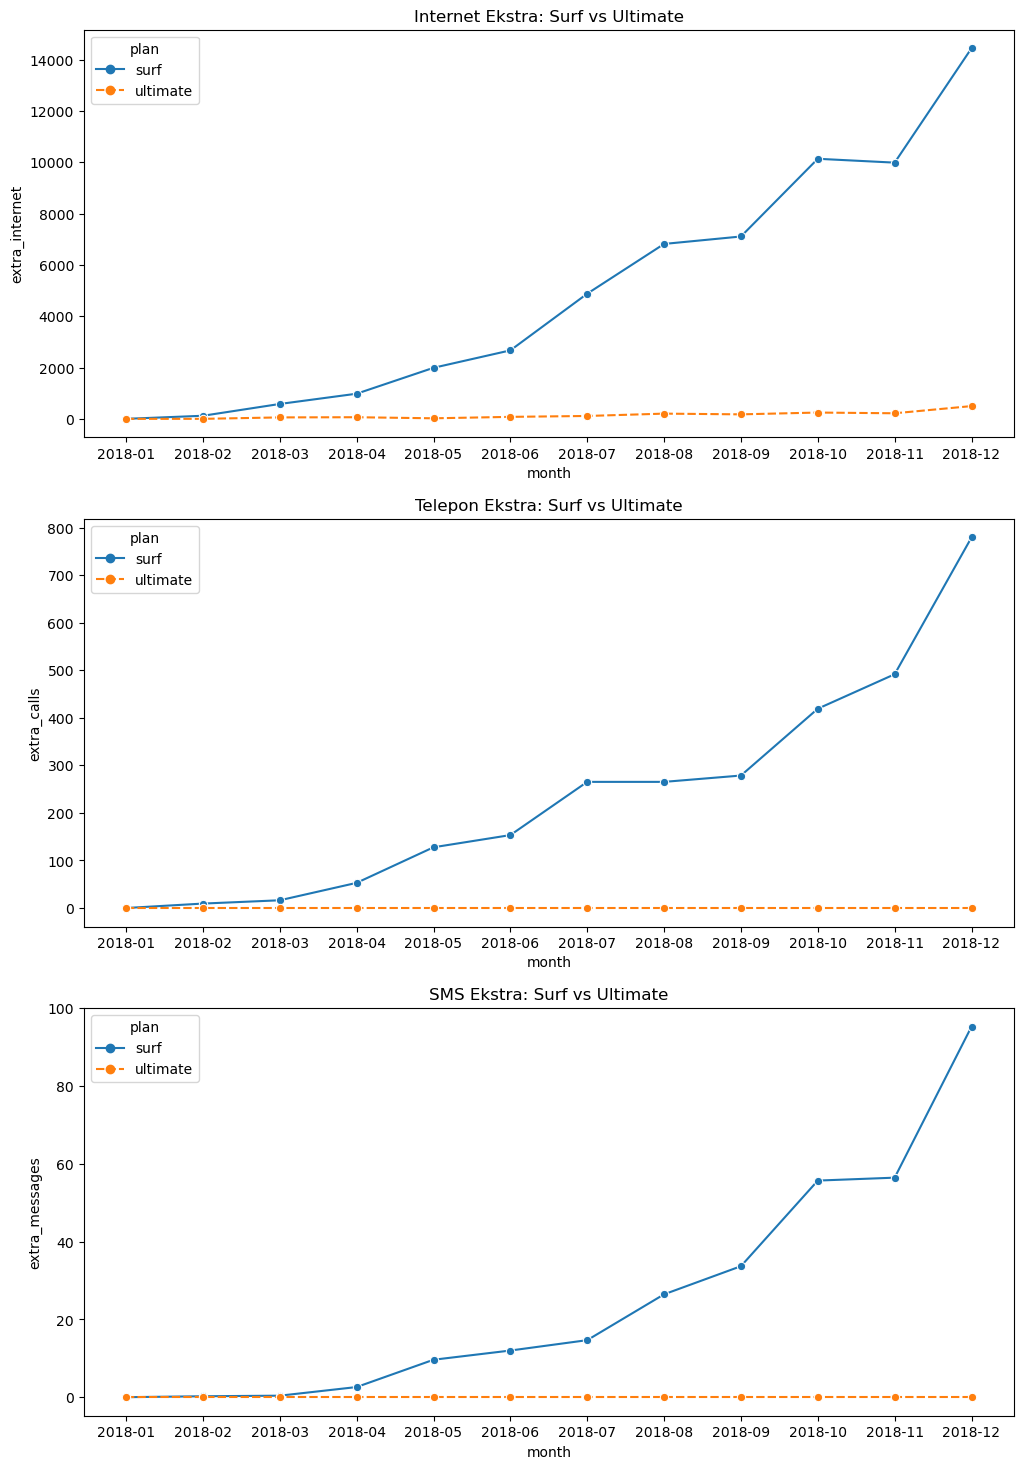

In [32]:
# Displays the visualization
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
plt.title('Internet Ekstra: Surf vs Ultimate')
sns.lineplot(data=income_extra, x='month', y='extra_internet', hue='plan', style="plan", markers=["o", "o"])

plt.subplot(3, 1, 2)
plt.title('Telepon Ekstra: Surf vs Ultimate')
sns.lineplot(data=income_extra, x='month', y='extra_calls', hue='plan', style="plan", markers=["o", "o"])

plt.subplot(3, 1, 3)
plt.title('SMS Ekstra: Surf vs Ultimate')
sns.lineplot(data=income_extra, x='month', y='extra_messages', hue='plan', style="plan", markers=["o", "o"])

plt.show()

**Findings:**
- There is a correlation between the increase in extra costs for internet, voice, and SMS packages.
- Specifically for surf packages, the extra costs from internet usage are significantly higher compared to voice calls and SMS.
- There is a significant surge in extra costs in December.
- The increase in extra costs is relatively moderate in the first half of the year (January to June), but accelerates rapidly in the second half (July to December).

**Insights:**
- The increase in customer extra fees is consistent across the different types of surf package services. It suggests that customers have higher demands for internet, voice, and SMS services than what is provided by the surf packages.

**Recommendation:**
- The company can focus on optimizing revenue from each of these service types. However, to maximize profits, more emphasis should be placed on promoting internet services.

We will analyze the average additional expenses incurred by customers for telephone, SMS, and internet services. The objective is to determine the extent of the excess demand for each service.

In [33]:
# Percentage of customers who take extra internet fees
dataset.loc[dataset.extra_internet > 0].groupby(['plan']).count()['user_id'] / dataset.groupby(['plan']).count()['user_id'] * 100

plan
surf        58.577952
ultimate     5.799151
Name: user_id, dtype: float64

In [34]:
# Average additional cost for internet per customer per package
dataset.loc[dataset.extra_internet > 0].groupby(['plan']).mean()['extra_internet']

plan
surf        66.514477
ultimate    40.634146
Name: extra_internet, dtype: float64

**Findings:**
- Only 5.8% of ultimate package users incur additional fees, while more than half (58.6%) of surf subscribers add extra charges.
- The average additional cost per user for the ultimate package is substantial, amounting to USD 40.6.

**Insights:**
- More than half of surf customers pay an average extra fee of USD 66.5, which is significantly higher than the regular surf package price of USD 20. In fact, the total additional cost surpasses the monthly cost of the ultimate package, which is USD 70, without considering the excess usage charges for calls and SMS.
- However, due to the limited number of ultimate package users incurring extra fees, the total extra revenue generated from ultimate customers appears to be less significant.

**Recommendations:**
- There is a greater opportunity to optimize revenue from internet services in the surf packages, making it essential to promote these offerings more effectively.

In [35]:
# Percentage of customers who take extra phone charges
dataset.loc[dataset.extra_calls > 0].groupby(['plan']).count()['user_id'] / dataset.groupby(['plan']).count()['user_id'] * 100

plan
surf        36.007828
ultimate          NaN
Name: user_id, dtype: float64

In [36]:
# Average additional cost for telephone per customer per package
dataset.loc[dataset.extra_calls > 0].groupby(['plan']).mean()['extra_calls']

plan
surf    5.17875
Name: extra_calls, dtype: float64

**Findings:**
- Approximately 36% of surf subscribers incur additional charges for calls, while no ultimate subscribers have extra charges for calls.
- The average call surcharge for surf subscribers is USD 5.2.

**Insights:**
- A significant percentage of surf subscribers opt for additional call charges, indicating a higher demand for call services beyond the package limits.
- In contrast, ultimate subscribers seem to utilize their allocated call minutes within the package without incurring extra charges.

**Recommendations:**
- Companies can consider offering flexible call options or packages with higher call minutes to cater to the needs of surf subscribers who frequently exceed their call limits.

In [37]:
# Percentage of subscribers who take extra sms charges
dataset.loc[dataset.extra_messages > 0].groupby(['plan']).count()['user_id'] / dataset.groupby(['plan']).count()['user_id'] * 100

plan
surf        21.200261
ultimate          NaN
Name: user_id, dtype: float64

In [38]:
# Average additional cost for sms per customer per package
dataset.loc[dataset.extra_messages > 0].groupby(['plan']).mean()['extra_messages']

plan
surf    0.945138
Name: extra_messages, dtype: float64

**Findings:**
- Similar to calls, only surf customers incur extra fees for SMS, with a percentage of 21.2%.
- The average extra SMS cost for surf subscribers is USD 0.945.

**Insights:**
- There are opportunities to optimize revenue from extra fees for surf subscribers across all service types, while the ultimate package focuses solely on internet services.
- The voice and SMS quotas provided by the Ultimate package seem to be sufficient for customer needs, as customers do not typically require additional quotas.

**Recommendations:**
- Promoting and incentivizing higher internet usage among ultimate package subscribers can potentially increase revenue from extra fees. The average extra cost incurred per customer is more than USD 40 per month, indicating potential for further internet consumption among ultimate package users.

In [39]:
# Total revenue per prepaid package
dataset.loc[dataset.total_cost > 0].groupby(['plan']).sum()['total_cost']

plan
surf        93555.84
ultimate    51156.00
Name: total_cost, dtype: float64

In [40]:
# Average revenue per customer from each plan
dataset.loc[dataset.total_cost > 0].groupby(['plan']).mean()['total_cost']

plan
surf        61.027945
ultimate    72.356436
Name: total_cost, dtype: float64

**Findings:**
- The surf package outperforms the ultimate package in terms of total revenue.
- The ultimate package has a higher average revenue per customer.

**Insights:**
- Despite the higher average revenue per subscriber of the ultimate package, the surf package generates more overall revenue for the company.

**Recommendations:**
- There is a need to prioritize the promotion of the surf package to further capitalize on its revenue potential.

Now, let's analyze the distribution of package usage to gain a deeper understanding of the characteristics of prepaid package users.

In [41]:
# Create surf-specific datasets
dataset_surf = dataset.query('plan == "surf"')
dataset_surf.head()

,user_id,month,gb_used,duration,sms,age,plan,reg_month,churn_month,city_code,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,extra_internet,extra_messages,extra_calls,total_extra_cost,total_cost
1,1001,2018-08,7,182.0,30.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,0,0.00,0.0,0.00,20.00
2,1001,2018-09,14,315.0,44.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,0,0.00,0.0,0.00,20.00
3,1001,2018-10,22,393.0,53.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,70,0.09,0.0,70.09,90.09
4,1001,2018-11,19,426.0,36.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,40,0.00,0.0,40.00,60.00
5,1001,2018-12,19,412.0,44.0,28,surf,2018-08,NaT,WA,...,20,10,0.03,0.03,surf,40,0.00,0.0,40.00,60.00


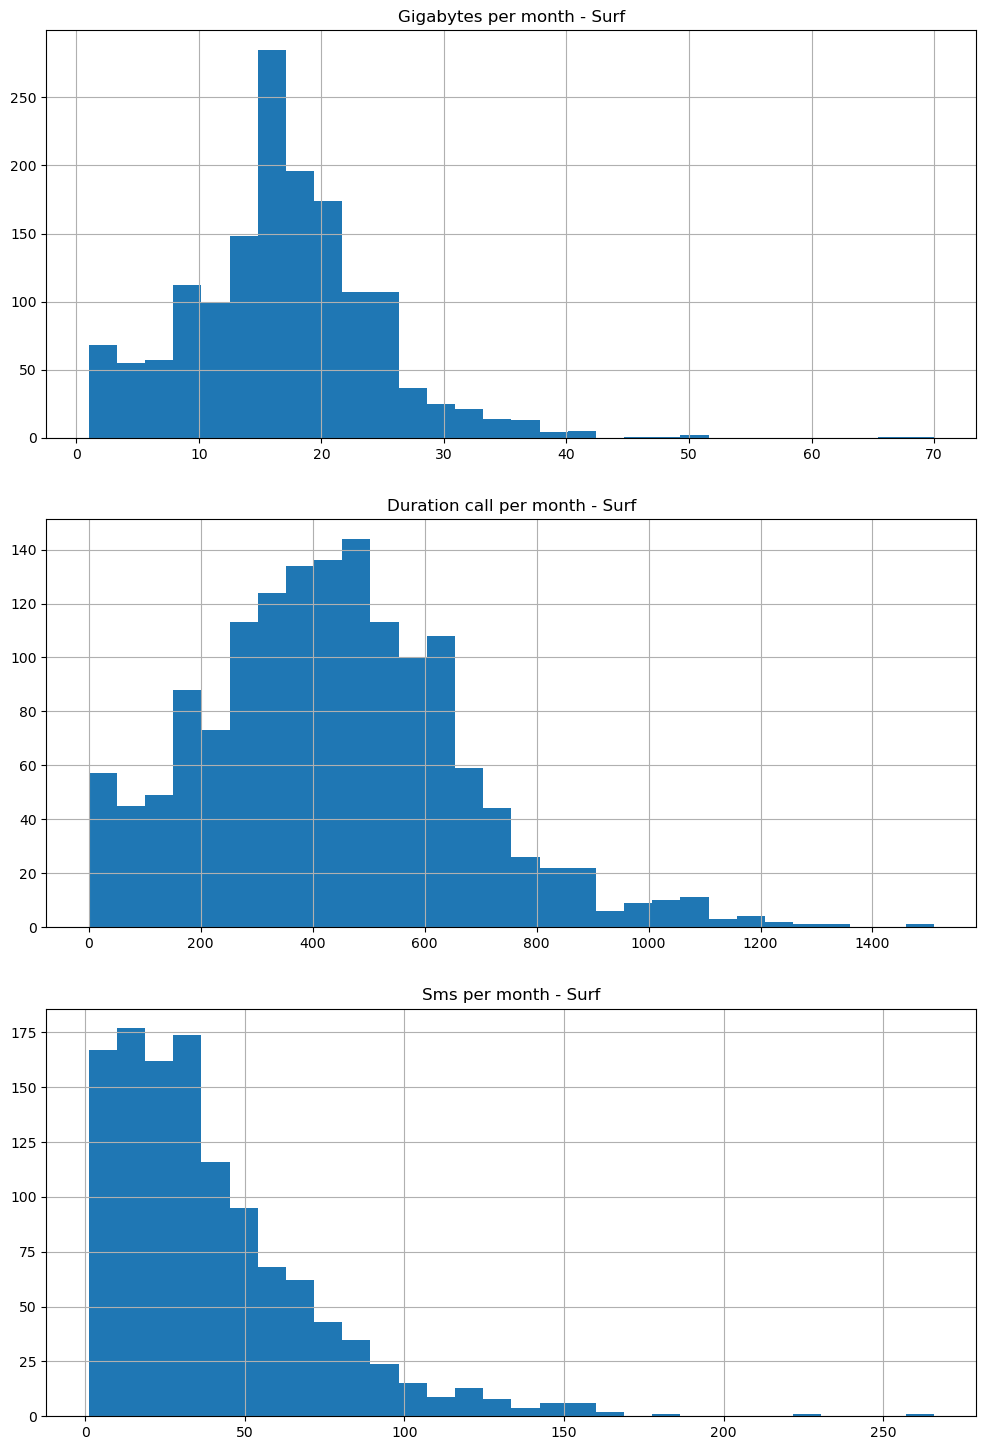

In [42]:
# Check the distribution of surf package service usage
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
dataset_surf['gb_used'].hist(bins=30)
plt.title('Gigabytes per month - Surf')

plt.subplot(3, 1, 2)
dataset_surf['duration'].hist(bins=30)
plt.title('Duration call per month - Surf')

plt.subplot(3, 1, 3)
dataset_surf['sms'].hist(bins=30)
plt.title('Sms per month - Surf')

plt.show()

In [43]:
# Checking the average (mean), median (50%), and standard deviation (std) in surf data
dataset_surf[['gb_used', 'duration', 'sms']].describe()

,gb_used,duration,sms
count,1533.000000,1505.000000,1189.000000
mean,16.834964,437.912957,39.547519
std,7.702584,229.552542,32.283109
min,1.000000,0.000000,1.000000
25%,12.000000,280.000000,16.000000
50%,17.000000,430.000000,32.000000
75%,21.000000,579.000000,54.000000
max,70.000000,1510.000000,266.000000


In [44]:
# Checking the variance of the surf data 
dataset_surf[['gb_used', 'duration', 'sms']].var()

gb_used        59.329795
duration    52694.369413
sms          1042.199129
dtype: float64

**Findings**
- The average usage of internet surfing services is 16.8 GB, which is close to the median of 17 GB. This indicates that users tend to consume a significant amount of data, exceeding the monthly quota limit of 15 GB provided by the surf package. Consequently, it is not surprising to observe a considerable number of extra costs incurred by internet users.
- The variance values for SMS and call duration are relatively high, indicating a wider distribution of data points compared to the average values.
- The average call duration is 437.9 minutes, while the average number of SMS sent is 39.5. These figures are below the respective quotas offered by the surf package, which provides 500 minutes of call duration and 50 SMS.

Now it's time to check the ultimate package distribution.

In [45]:
# Create custom dataset for ultimate package
dataset_ultimate = dataset.query('plan == "ultimate"')
dataset_ultimate.head()

,user_id,month,gb_used,duration,sms,age,plan,reg_month,churn_month,city_code,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,extra_internet,extra_messages,extra_calls,total_extra_cost,total_cost
0,1000,2018-12,2,124.0,11.0,45,ultimate,2018-12,NaT,GA,...,70,7,0.01,0.01,ultimate,0,0.0,0.0,0.0,70.0
19,1006,2018-11,3,10.0,15.0,73,ultimate,2018-11,2018-12,CA,...,70,7,0.01,0.01,ultimate,0,0.0,0.0,0.0,70.0
20,1006,2018-12,32,59.0,139.0,73,ultimate,2018-11,2018-12,CA,...,70,7,0.01,0.01,ultimate,14,0.0,0.0,14.0,84.0
26,1008,2018-10,17,476.0,21.0,53,ultimate,2018-08,NaT,FL,...,70,7,0.01,0.01,ultimate,0,0.0,0.0,0.0,70.0
27,1008,2018-11,24,446.0,37.0,53,ultimate,2018-08,NaT,FL,...,70,7,0.01,0.01,ultimate,0,0.0,0.0,0.0,70.0


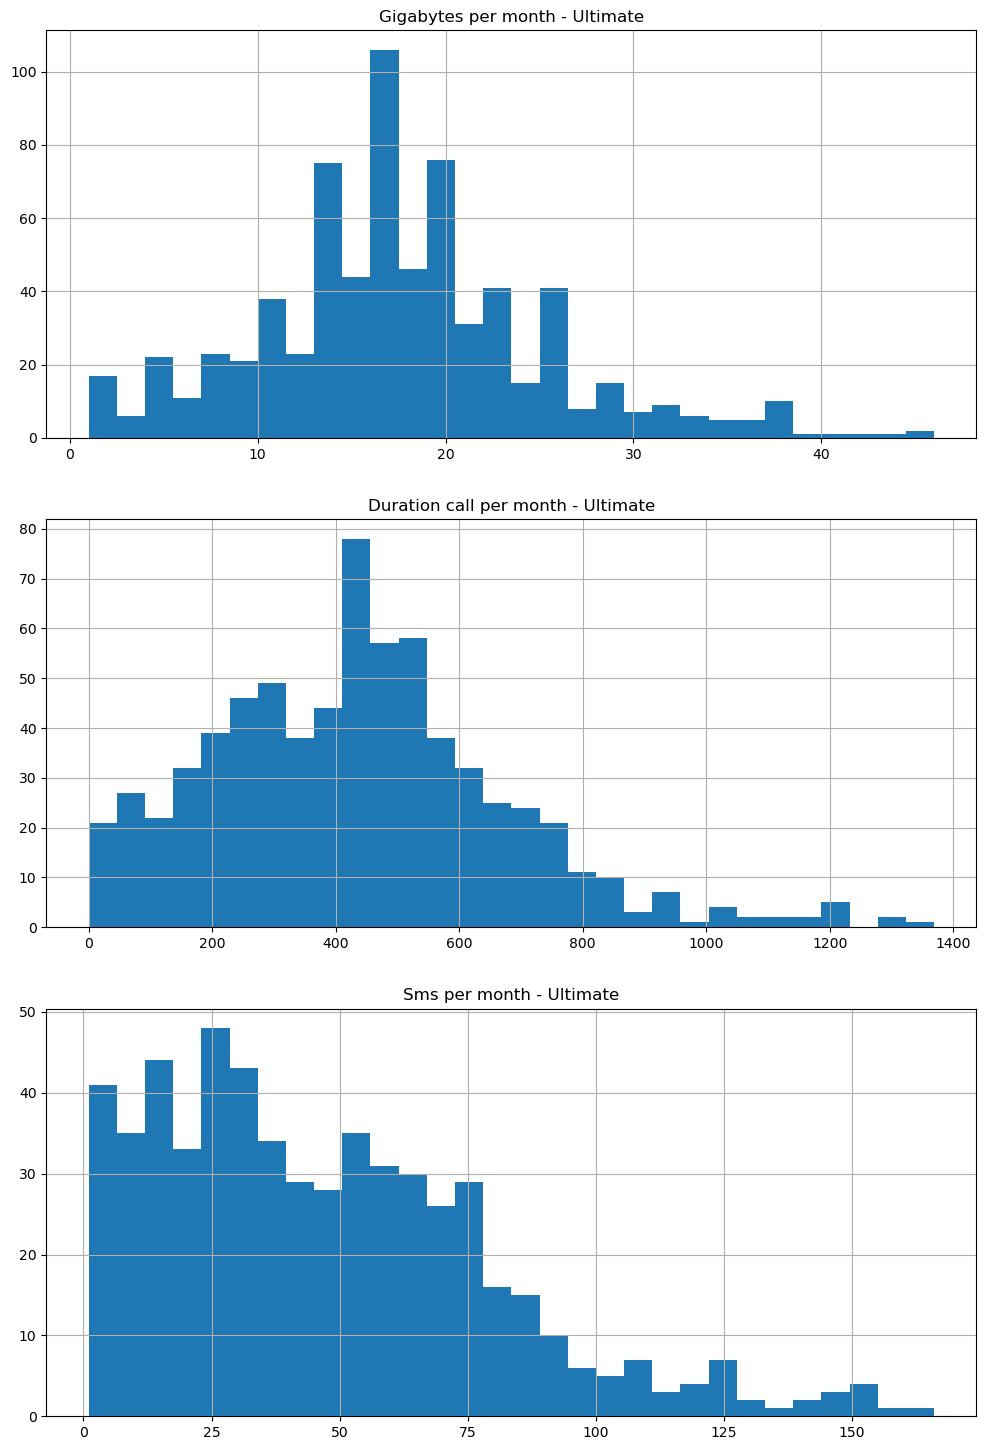

In [46]:
# Check the distribution of the use of the ultimate package service
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
dataset_ultimate['gb_used'].hist(bins=30)
plt.title('Gigabytes per month - Ultimate')

plt.subplot(3, 1, 2)
dataset_ultimate['duration'].hist(bins=30)
plt.title('Duration call per month - Ultimate')

plt.subplot(3, 1, 3)
dataset_ultimate['sms'].hist(bins=30)
plt.title('Sms per month - Ultimate')

plt.show()

In [47]:
# Check the mean (mean), median (50%), and standard deviation (std) of the data
dataset_ultimate[['gb_used', 'duration', 'sms']].describe()

,gb_used,duration,sms
count,707.000000,701.000000,573.000000
mean,17.359264,434.446505,46.699825
std,7.678448,238.286200,32.997308
min,1.000000,0.000000,1.000000
25%,13.000000,262.000000,21.000000
50%,17.000000,427.000000,41.000000
75%,21.000000,566.000000,66.000000
max,46.000000,1369.000000,166.000000


In [48]:
# Checking the variance of the ultimate data
dataset_ultimate[['gb_used', 'duration', 'sms']].var()

gb_used        58.958565
duration    56780.313206
sms          1088.822325
dtype: float64

**Findings:**
- The average internet usage in the ultimate package is approximately 17.3 GB, which is similar to the surf package. However, the ultimate package offers a higher quota of 30 GB. This suggests that ultimate package users tend to consume a smaller portion of their provided quota, resulting in fewer extra costs for internet services.
- The variances in call duration and SMS usage in the ultimate package are comparable to those in the surf package.
- The average call duration (434.4) and SMS usage (46.7) in the ultimate package are significantly lower than the respective quotas of 3,000 minutes and 1,000 SMS.
- The average usage of calls and SMS in the ultimate package is similar to that of the surf package, despite the higher quotas offered in the ultimate package. This indicates that ultimate package users are not exceeding the allocated quotas for these services, resulting in no additional costs.

**Insights:**
- Overall, the level of internet, call, and SMS usage is relatively similar for both the surf and ultimate packages.
- The variances in call duration and SMS usage suggest a wide range of usage patterns, with some users exceeding the quotas significantly.
- The histogram of package usage tends to be right-skewed, indicating that the majority of users utilize a lower amount of the provided quota.

**Recommendations:**
- Both the surf and ultimate packages can be maintained as they are equally profitable. The data shows that the usage of quota is relatively similar between the two packages, as well as the fees paid by the customers.

We need to examine the distribution of other categories, such as age and city, to gain additional insights from the data. Let's analyze these categories.

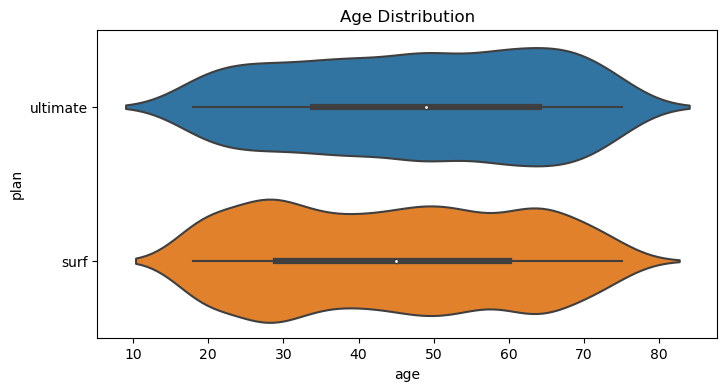

In [49]:
# Check usage distribution by age
plt.figure(figsize=(8, 4))
sns.violinplot(data=dataset, x='age', y='plan')
plt.title('Age Distribution')
plt.show()

In [50]:
# Let's analyze the correlation between age and the total costs incurred by users
dataset['total_cost'].corr(dataset['age'])

0.04054072471190526

<Axes: xlabel='age', ylabel='total_cost'>

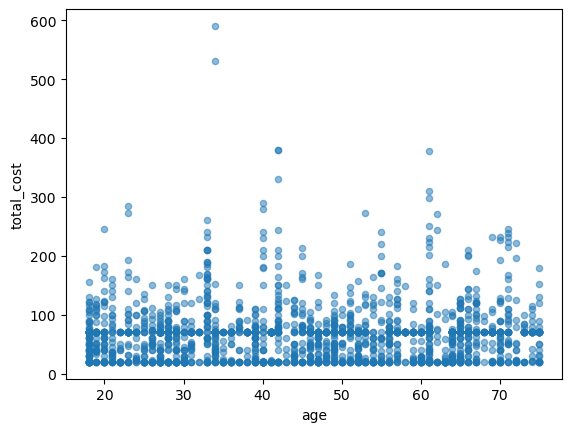

In [51]:
# Visualization of the correlation between age and total costs
dataset.plot(x='age', y='total_cost', kind='scatter', alpha=0.5) 

**Findings**
- The distribution of age among users of surf packages shows a larger proportion of younger individuals (<30 years old), while the ultimate package is for old age (> 60 years old). However, the difference in the number of customers across different age groups is not significant.
- There is a weak correlation of 4% between age and the total costs incurred by users. This suggests that age is not a strong determining factor for the total subscription fee.

**Insights**
- Younger individuals tend to opt for the more affordable surf packages. This could be attributed to their income levels and preferences.
- Overall, the level of prepaid service consumption does not seem to be strongly dependent on age.
- Although younger customers choose cheaper packages, they end up incurring similar extra subscription fees as older customers who opt for more expensive packages.

**Recommendations**
- It would be beneficial to intensify promotions of surf packages among individuals under the age of 30, while targeting the ultimate package towards older individuals in the 50-70 age range.

In [52]:
# Checking the number of cities
dataset['city_code'].nunique()

42

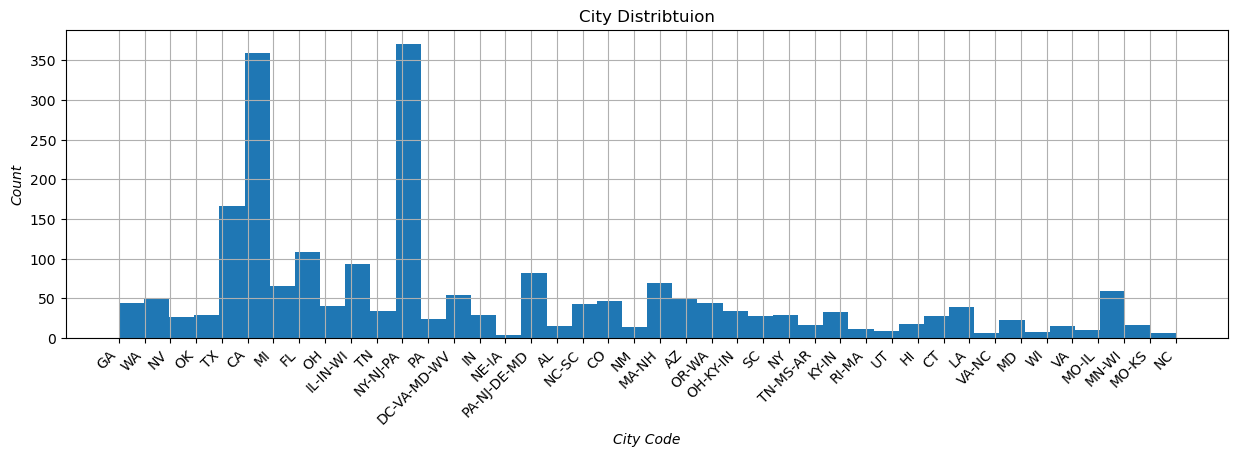

In [53]:
# Check the distribution of the number of users per city
plt.figure(figsize=(15, 4))
dataset['city_code'].hist(bins=42)
plt.title('City Distribtuion')
plt.xticks(rotation=45, ha='right')
plt.xlabel('City Code', fontstyle='italic')
plt.ylabel('Count', fontstyle='italic')
plt.show()

In [54]:
# Create a new dataset grouping users by city
dataset_city_count = dataset.pivot_table(index='city_code', columns='plan', values='user_id', aggfunc='count').fillna(0).reset_index()
dataset_city_count['total'] = dataset_city_count['surf'] + dataset_city_count['ultimate']
dataset_city_count

plan,city_code,surf,ultimate,total
0,AL,10.0,5.0,15.0
1,AZ,31.0,19.0,50.0
2,CA,221.0,138.0,359.0
3,CO,40.0,7.0,47.0
4,CT,25.0,3.0,28.0
5,DC-VA-MD-WV,32.0,22.0,54.0
6,FL,59.0,49.0,108.0
7,GA,21.0,23.0,44.0
8,HI,18.0,0.0,18.0
9,IL-IN-WI,51.0,42.0,93.0


In [55]:
# Create a new dataset of income grouping by city
dataset_city = dataset.pivot_table(index='city_code', columns='plan', values='total_cost', 
                                   aggfunc='sum').fillna(0).reset_index()
dataset_city['total'] = dataset_city['surf'] + dataset_city['ultimate']
dataset_city

plan,city_code,surf,ultimate,total
0,AL,450.15,350.0,800.15
1,AZ,1997.79,1330.0,3327.79
2,CA,12953.92,10010.0,22963.92
3,CO,2430.78,490.0,2920.78
4,CT,2069.03,210.0,2279.03
5,DC-VA-MD-WV,1785.34,1603.0,3388.34
6,FL,4018.52,3437.0,7455.52
7,GA,1678.40,1645.0,3323.40
8,HI,1939.48,0.0,1939.48
9,IL-IN-WI,2105.14,3045.0,5150.14


In [56]:
# Checking the data description
dataset_city.describe()

plan,surf,ultimate,total
count,42.000000,42.000000,42.000000
mean,2227.520000,1218.000000,3445.520000
std,3288.941419,1784.558386,4813.481333
min,60.000000,0.000000,60.000000
25%,491.402500,280.000000,926.540000
50%,1549.975000,595.000000,2170.710000
75%,2357.347500,1382.500000,3333.242500
max,17361.510000,10010.000000,22963.920000


**Findings**
- The number of users varies significantly across cities, with some cities having a much higher user count than others.
- Cities with the highest number of users are CA (359) and NY-NJ-PA (370). Other cities with potential user bases include FL (108), TX (166), IL-IN-WI (93), and PA-NJ-DE-MD (82).
- CA (USD 22,963.92) and NY-NJ-PA (USD 22,163.51) generate the highest revenue, aligning with their large user populations.
- Some cities do not have any ultimate package subscribers.
- The average revenue from surf packages (USD 2,227.5) is nearly double that of the ultimate package (USD 1,218), despite the ultimate package being priced higher.

**Insights**
- Although NY-NJ-PA has a higher user count than CA, the revenue generated from CA is higher, indicating potentially higher spending per user.
- The average revenue from both surf and ultimate packages exceeds the median, suggesting a significant number of users are paying additional fees.

**Recommendations**
- Megaline should consider increasing promotional efforts in cities with a lower user count. However, gathering additional data is necessary to understand the reasons behind the smaller user base in these cities. Factors such as low population, market dominance by competitors, or limited telecommunication infrastructure in remote areas may contribute.
- Further investigation is required for cities where no ultimate package subscriptions exist before considering increased promotion of the ultimate package in those areas.

## Hypothesis Testing

We have completed the data analysis process, and now it is time to test the initial hypotheses:

1. Hypothesis: The average revenue of Ultimate and Surf phone package users is different.
   - Null hypothesis (H0): The average revenue of Ultimate and Surf phone package users is the same.
   - Alternative hypothesis (HA): The average revenue of Ultimate and Surf phone package users is different.

To test this hypothesis, we can perform a statistical test such as a t-test to compare the means of the two groups and determine if they are significantly different.

2. Hypothesis: The average income of users in the NY-NJ area is different from the income of users from other regions.
   - Null hypothesis (H0): The average income of users in the NY-NJ area is the same as the income of users from other regions.
   - Alternative hypothesis (HA): The average income of users in the NY-NJ area is different from the income of users from other regions.

To test this hypothesis, we can also use a statistical test to compare the means of income between the NY-NJ area and other regions.

By conducting these statistical tests, we can determine if there is sufficient evidence to support or reject these hypotheses.

### Hypothesis Test 1

We will test the hypothesis that the average income of users of Ultimate and Surf phone packages is different. Previously, we found that the average income values for these two packages are indeed different, with surf income being higher than ultimate. However, we need to apply appropriate statistical methods to validate this observation.

- Null Hypothesis (H0): The average income of Ultimate and Surf phone package users is the same.
- Alternative Hypothesis (HA): The average income of Ultimate and Surf phone package users is different.

To test this hypothesis, we can use the `st.ttest_ind()` method, which is suitable for comparing the means of two different statistical populations. In this case, the two populations we will compare are the *dataset_surf* and *dataset_ultimate*.

We will set the significance level (alpha) to 5%. If the resulting p-value is less than 0.05, it indicates that the average incomes of the two populations are significantly different, leading us to reject the null hypothesis (H0). Conversely, if the p-value is greater than 0.05, we fail to reject the null hypothesis.

Before performing the t-test, we should also check whether the variances of the two datasets are equal.

In [57]:
# Checking dataset_surf variants
dataset_surf['total_cost'].var()

3079.2073053703643

In [58]:
# Checking the variance of the dataset_ultimate
dataset_ultimate['total_cost'].var()

132.13906263147837

These two datasets have different variants, so we will set equal_var to False.

In [59]:
# Testing the hypothesis
alpha = 0.05
results = st.ttest_ind(dataset_surf['total_cost'], dataset_ultimate['total_cost'], equal_var=False)
print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

p-value: 3.3688804989792594e-14
We reject the null hypothesis


Based on the results of testing this hypothesis, we reject the null hypothesis (H0) and accept the alternative hypothesis (HA). Therefore, we can conclude that the average income of users of Ultimate and Surf phone plans is indeed different.

### Hypothesis Test 2

*The average income of users in the NY-NJ area is different from the income of users from other regions.*

To test this hypothesis, we will conduct a statistical analysis comparing the average income of users in the NY-NJ area with the average income of users from other regions.

- Our null hypothesis (H0) states that "The average income of users in the NY-NJ area is the same as the income of users from other regions."
- The alternative hypothesis (HA) is "The average income of users in the NY-NJ area differs from the income of users from other regions."

We will use a significance level (alpha) of 5%. If the p-value is less than 0.05, we reject the null hypothesis and conclude that the average income of users in the NY-NJ area is significantly different from the income of users from other regions.

Before conducting the hypothesis test, it is important to check the assumptions, such as the normality and equal variance of the income data for the NY-NJ area and other regions.

In [60]:
# Create a new dataset containing users from the NY-NJ region
dataset_NYNJ = dataset_city.query('city_code == "NY-NJ"')
dataset_NYNJ

plan,city_code,surf,ultimate,total


There seems to be no data. We need to check the unique value of `city_code`

In [61]:
# Examine the list of city codes in the dataset_city
dataset_city['city_code'].unique()

array(['AL', 'AZ', 'CA', 'CO', 'CT', 'DC-VA-MD-WV', 'FL', 'GA', 'HI',
       'IL-IN-WI', 'IN', 'KY-IN', 'LA', 'MA-NH', 'MD', 'MI', 'MN-WI',
       'MO-IL', 'MO-KS', 'NC', 'NC-SC', 'NE-IA', 'NM', 'NV', 'NY',
       'NY-NJ-PA', 'OH', 'OH-KY-IN', 'OK', 'OR-WA', 'PA', 'PA-NJ-DE-MD',
       'RI-MA', 'SC', 'TN', 'TN-MS-AR', 'TX', 'UT', 'VA', 'VA-NC', 'WA',
       'WI'], dtype=object)

Upon closer examination, it appears that there is no specific city code for NY-NJ; instead, we have separate codes for NY and NY-NJ-PA. This discrepancy might be attributed to the way the city data is grouped by the operator. To conduct a more accurate analysis, we will reorganize the city column by creating distinct groups for NY-NJ and Others.

In [62]:
# Create a function to change the city code
def city_code_new(city):
    if 'NY' in city:
        return 'NY-NJ'
    else:
        return 'Others'

In [63]:
# Implemented the function to generate a new city code
dataset_city['new_city_code'] = dataset_city['city_code'].apply(city_code_new)
dataset_city

plan,city_code,surf,ultimate,total,new_city_code
0,AL,450.15,350.0,800.15,Others
1,AZ,1997.79,1330.0,3327.79,Others
2,CA,12953.92,10010.0,22963.92,Others
3,CO,2430.78,490.0,2920.78,Others
4,CT,2069.03,210.0,2279.03,Others
5,DC-VA-MD-WV,1785.34,1603.0,3388.34,Others
6,FL,4018.52,3437.0,7455.52,Others
7,GA,1678.40,1645.0,3323.40,Others
8,HI,1939.48,0.0,1939.48,Others
9,IL-IN-WI,2105.14,3045.0,5150.14,Others


We already have a new column that groups cities into two, namely NY-NJ and Others. We will divide this dataset into two groups to test together later.

In [64]:
# Create a new dataset containing users from the NY-NJ region
dataset_city_nynj = dataset_city.query('new_city_code == "NY-NJ"').reset_index()
dataset_city_nynj

plan,index,city_code,surf,ultimate,total,new_city_code
0,24,NY,2137.05,0.0,2137.05,NY-NJ
1,25,NY-NJ-PA,17361.51,4802.0,22163.51,NY-NJ


In [65]:
# Create a new dataset containing users other than the NY-NJ region
dataset_city_others = dataset_city.query('new_city_code == "Others"').reset_index()
dataset_city_others

plan,index,city_code,surf,ultimate,total,new_city_code
0,0,AL,450.15,350.0,800.15,Others
1,1,AZ,1997.79,1330.0,3327.79,Others
2,2,CA,12953.92,10010.0,22963.92,Others
3,3,CO,2430.78,490.0,2920.78,Others
4,4,CT,2069.03,210.0,2279.03,Others
5,5,DC-VA-MD-WV,1785.34,1603.0,3388.34,Others
6,6,FL,4018.52,3437.0,7455.52,Others
7,7,GA,1678.40,1645.0,3323.40,Others
8,8,HI,1939.48,0.0,1939.48,Others
9,9,IL-IN-WI,2105.14,3045.0,5150.14,Others


In [66]:
# Calculates the variance
dataset_city_nynj['total'].var()

200529550.06579998

In [67]:
dataset_city_others['total'].var()

15135927.59952923

Both have different variances, so we'll use equal_var=False.

In [68]:
# Testing the hypothesis
alpha = 0.05
results = st.ttest_ind(dataset_city_nynj['total'], dataset_city_others['total'], equal_var=False)
print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

p-value: 0.5286827314479272
We accept the null hypothesis


Based on the results of the hypothesis test, we have made the decision to accept the null hypothesis, which states that the average revenue from users in the NY-NJ area is the same as the revenue from users in other areas.

## Conclusion

We have completed the analysis process and conducted hypothesis testing. Based on the results, we have drawn the following conclusions:

1. The average income of the Surf and Ultimate packages is significantly different, as indicated by the hypothesis test.
2. The average package revenue in different cities, including NY-NJ, is similar to other cities, suggesting no significant difference.
3. Surf package revenue tends to be higher than Ultimate package revenue, despite the higher subscription fees of the Ultimate package. This difference can be attributed to Surf users consuming a larger service quota and incurring higher extra fees.
4. The Surf package is more popular among younger users (<30 years old), while the Ultimate package is more popular among older users. There is no correlation between the user's age and the total subscription fee.
5. The total subscription fee of Surf package users surpasses that of the Ultimate package due to the additional fees incurred.
6. The operator's recommendation is to prioritize the promotion of the Surf package, as it appeals to price-sensitive users and ultimately generates higher average revenue per user compared to the Ultimate package.
7. However, it is also important to promote the Ultimate package as it offers significant benefits, especially in cities where there are currently no users of this package. Further analysis is needed to understand the reasons behind the lack of Ultimate package users in these cities.